In [1]:
#Importing Packages and dataset
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras import backend as K
import sklearn
from sklearn.model_selection import train_test_split

#Setting up the dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

#Reshaping the data as per the model requirement
x_train = x_train.reshape(-1, 28,28, 1)/255
x_test = x_test.reshape(-1, 28,28, 1)/255

#Splitting the data for validation
X,X_val,Y,Y_val = train_test_split(x_train,x_train,test_size=0.2)

In [2]:
#Define the autoencoder model
class AutoEncoder(tf.keras.Model):

    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = tf.keras.Sequential(
            [
            Conv2D(256, (3, 3), activation='relu', padding='same'),
            Conv2D(128, (3, 3), activation='relu', padding='same'),
            Conv2D(64, (3, 3), activation='relu', padding='same'),
            MaxPooling2D(pool_size=(2, 2)),
            Conv2D(32, (3, 3), activation='relu', padding='same'),
            Conv2D(16, (3, 3), activation='relu', padding='same'),
            Conv2D(8, (1, 1), activation='relu', padding='same'),
            MaxPooling2D(pool_size=(2, 2)),
            Conv2D(4, (3, 3), activation='relu', padding='same'),
            Conv2D(2, (1, 1), activation='relu', padding='same'),
            Conv2D(1, (1, 1), activation='relu', padding='same'),
            ]
        )
        self.decoder = tf.keras.Sequential(
            [
            Conv2D(2, (1, 1), activation='relu', padding='same'),
            Conv2D(4, (3, 3), activation='relu', padding='same'),
            Conv2D(8, (3, 3), activation='relu', padding='same'),
            UpSampling2D(size=(2, 2)),
            Conv2D(16, (3, 3), activation='relu', padding='same'),
            Conv2D(32, (3, 3), activation='relu', padding='same'),
            Conv2D(64, (3, 3), activation='relu', padding='same'),
            UpSampling2D(size=(2, 2)),
            Conv2D(128, (3, 3), activation='relu', padding='same'),
            Conv2D(256, (3, 3), activation='relu', padding='same'),
            Conv2D(1, (3, 3), activation='tanh', padding='same'),
            ]
        )
        self.train()

    def call(self, inputs):
        if self.e:
            inputs = self.encoder(inputs)
        if self.d:
            inputs = self.decoder(inputs)
        return inputs

    def encode(self):
        self.e = True
        self.d = False

    def decode(self):
        self.e = False
        self.d = True

    def train(self):
        self.e = True
        self.d = True

In [3]:
#Create a object of model class
model = AutoEncoder()
#Compile the model with MSE loss and Adam optimizer
model.compile(loss='mean_squared_error', optimizer = Adam())

In [4]:
#Build the model
model.build(input_shape = (None,28,28,1))

In [5]:
#Print Summary
model.encoder.summary()
model.decoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 256)       2560      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 128)       295040    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        73792     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 32)        18464     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 16)        4624      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 8)         1

In [6]:
model_saver = tf.keras.callbacks.ModelCheckpoint("model_weights.h5", 
                                                 monitor='val_loss', verbose=1, 
                                                 save_best_only=True, 
                                                 save_weights_only=False, 
                                                 mode='auto')

In [7]:
#Train the model
history = model.fit(X,Y,epochs = 3,validation_data = (X_val,Y_val), batch_size = 32,callbacks = [model_saver])

Epoch 1/3
1500/1500 [==============================] - ETA: 0s - loss: 0.0107WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0032s vs `on_test_batch_end` time: 0.0122s). Check your callbacks.

Epoch 00001: val_loss improved from inf to 0.00492, saving model to model_weights.h5
1500/1500 [==============================] - 83s 56ms/step - loss: 0.0107 - val_loss: 0.0049
Epoch 2/3
1500/1500 [==============================] - ETA: 0s - loss: 0.0038
Epoch 00002: val_loss improved from 0.00492 to 0.00326, saving model to model_weights.h5
1500/1500 [==============================] - 83s 55ms/step - loss: 0.0038 - val_loss: 0.0033
Epoch 3/3
1500/1500 [==============================] - ETA: 0s - loss: 0.0032
Epoch 00003: val_loss did not improve from 0.00326
1500/1500 [==============================] - 83s 55ms/step - loss: 0.0032 - val_loss: 0.0033


In [8]:
#Setup Encoding Mode
model.encode()
#Encode 10 sample images
encodings = model.predict(x_test[:10])

In [9]:
#Setup Decoding Mode
model.decode()
#Decode 10 sample images
decodings = model.predict(encodings)

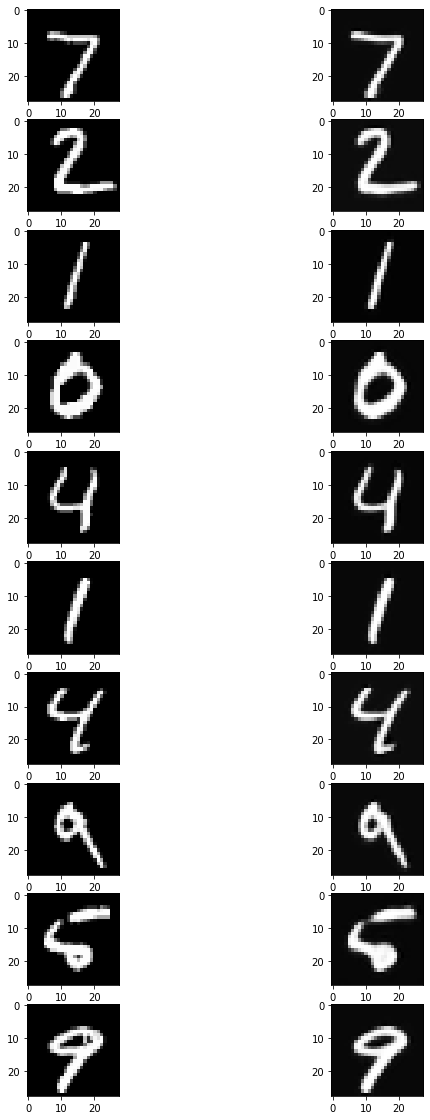

In [10]:
#Plotting original and extracted images
w=10
h=10
fig=plt.figure(figsize=(10, 20))
columns = 2
rows = 10
j = 0
k = 0
for i in range(1, columns*rows +1):
    if i%2 == 0:
        img = decodings[j,...,0]
        j+=1
    else:
        img = x_test[k,...,0]
        k+=1
    fig.add_subplot(rows, columns, i)
    plt.imshow(img,cmap = 'gray')
plt.show()